<link rel='stylesheet' href='../assets/css/main.css'/>

[<< back to main index](../README.md)

# Logistic Regression in Spark  - Credit Card Approval (Demo)

### Overview
Instructor to demo this on screen.
 
### Builds on
None

### Run time
approx. 20-30 minutes

### Notes

Spark has a logistic regression function called Logistic Regression.

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

## Sigmoid Curve

Let's generate a sigmoid curve in python!

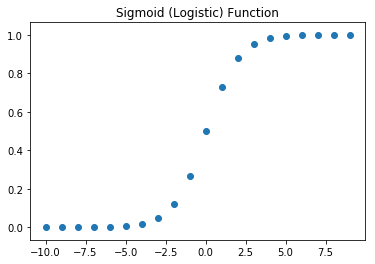

In [3]:
import numpy as np
# plot sigmoid curve
x = np.arange(-10.,10.,1.)
b = 0 # intercept
m = 1 # slope
sigmoid = lambda x,b,m: np.exp((b + m*x)) / (1 + np.exp((b + m*x)))
y = sigmoid(x,b,m)
plt.scatter(x,y)
plt.title("Sigmoid (Logistic) Function")


## Step 1: Credit Approval Data

Here is the sample data we are looking at:

| score | approved | 
|-------|----------| 
| 550   | 0        | 
| 750   | 1        | 
| 680   | 1        | 
| 650   | 0        | 
| 450   | 0        | 
| 800   | 1        | 
| 775   | 1        | 
| 525   | 0        | 
| 620   | 0        | 
| 705   | 0        | 
| 830   | 1        | 
| 610   | 1        | 
| 690   | 0        | 


## Step 2: Let's visualize the data

In [4]:
mydata = pd.DataFrame({'score' : [550., 750., 680., 650., 450., 800., 775., 525., 620., 705., 830., 610., 690.],
              'approved' : [0,1,1,0,0,1,1,0,0,0,1,1,0]
             })

mydata



,approved,score
0,0,550.0
1,1,750.0
2,1,680.0
3,0,650.0
4,0,450.0
5,1,800.0
6,1,775.0
7,0,525.0
8,0,620.0
9,0,705.0


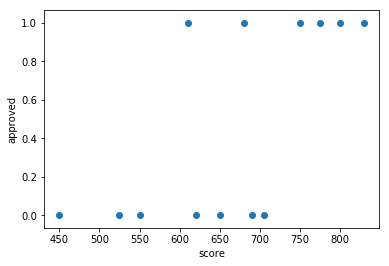

In [5]:
plt.scatter(mydata.score,mydata.approved)
plt.xlabel('score')
plt.ylabel('approved')

## Step 3: Convert dataframe to Spark and Prepare feature vector

We need to firstconvert the dataframe to spark, and then prepare the feature vector.



In [31]:
spark_credit = spark.createDataFrame(mydata)
assembler = VectorAssembler(inputCols=["score"], outputCol="features")
featureVector = assembler.transform(spark_credit)
featureVector = featureVector.withColumn("label",featureVector.approved)
featureVector.show()


+--------+-----+--------+-----+
|approved|score|features|label|
+--------+-----+--------+-----+
|       0|550.0| [550.0]|    0|
|       1|750.0| [750.0]|    1|
|       1|680.0| [680.0]|    1|
|       0|650.0| [650.0]|    0|
|       0|450.0| [450.0]|    0|
|       1|800.0| [800.0]|    1|
|       1|775.0| [775.0]|    1|
|       0|525.0| [525.0]|    0|
|       0|620.0| [620.0]|    0|
|       0|705.0| [705.0]|    0|
|       1|830.0| [830.0]|    1|
|       1|610.0| [610.0]|    1|
|       0|690.0| [690.0]|    0|
+--------+-----+--------+-----+




## Step 3: Run logistic regression

In [ ]:



mylogit = glm( approved ~ score, data=mydata, family="binomial")

# calculate some data
mydata$prob = predict (mylogit, newdata=mydata, type = "response")
print(mydata)

In [77]:

lr = LogisticRegression(maxIter=50, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(featureVector)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [0.00231936473739]
Intercept: -1.697546464447156


In [40]:
lrModel.summary.predictions.show()

+--------+-----+--------+-----+--------------------+--------------------+----------+
|approved|score|features|label|       rawPrediction|         probability|prediction|
+--------+-----+--------+-----+--------------------+--------------------+----------+
|       0|550.0| [550.0]|  0.0|[0.42189585888523...|[0.60393682312240...|       0.0|
|       1|750.0| [750.0]|  1.0|[-0.0419770885918...|[0.48950726855595...|       1.0|
|       1|680.0| [680.0]|  1.0|[0.12037844302514...|[0.53005832166779...|       0.0|
|       0|650.0| [650.0]|  0.0|[0.18995938514670...|[0.54734755549913...|       0.0|
|       0|450.0| [450.0]|  0.0|[0.65383233262376...|[0.65787354968202...|       0.0|
|       1|800.0| [800.0]|  1.0|[-0.1579453254610...|[0.46059555225819...|       1.0|
|       1|775.0| [775.0]|  1.0|[-0.0999612070264...|[0.47503048656856...|       1.0|
|       0|525.0| [525.0]|  0.0|[0.47987997731987...|[0.61771953276060...|       0.0|
|       0|620.0| [620.0]|  0.0|[0.25954032726826...|[0.5645232907

The output lists approval & estimated probabilities

In [ ]:
   score    approved        prob
1    550        0       0.056627207
2    750        1       0.803539879
3    680        1       0.482763979
4    650        0       0.331324127
5    450        0       0.007219373
6    800        1       0.921575779
7    775        1       0.873940664
8    525        0       0.034202204
9    620        0       0.208262068
10   705        0       0.612710719
11   830        1       0.956776400
12   610        1       0.175590878
13   690        0       0.535466724

In [33]:

# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

objectiveHistory:
0.6901856760188042
0.6899327462112606
0.6898596572878024
0.6897755898678963
0.6890411819005514
0.6877422034867855
0.6868231380259231
0.6866303048864236
0.6860730569628928
0.6858904394799109
0.6853725490572904
areaUnderROC: 0.8571428571428572


LogisticRegression_475797ed94d976fa9028

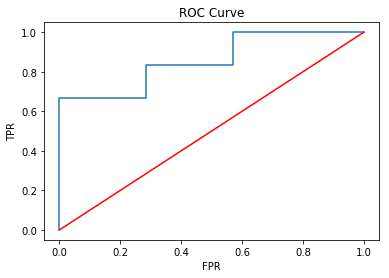

In [30]:
# ROC

roc_df = trainingSummary.roc.toPandas()

plt.plot(roc_df['FPR'], roc_df['TPR'])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.plot([0.0, 1.0], [0.0, 1.0], 'r')

## Step 4: Visualize data and logit model

root
 |-- approved: long (nullable = true)
 |-- score: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



[]

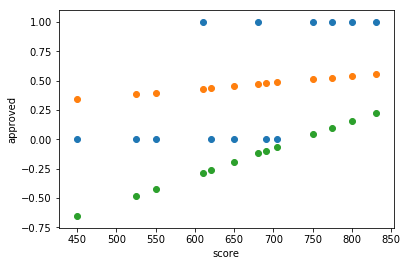

In [75]:
plt.scatter(mydata.score,mydata.approved)
plt.xlabel('score')
plt.ylabel('approved')
lrModel.summary.predictions.printSchema()
probabilities = lrModel.summary.predictions.select('score', 'rawPrediction', 'probability').toPandas()
probabilities[['raw1','raw2']] = pd.DataFrame(probabilities.rawPrediction.values.tolist())
probabilities[['prob1','prob2']] = pd.DataFrame(probabilities.probability.values.tolist())
plt.scatter(probabilities['score'], probabilities['prob2'])
plt.scatter(probabilities['score'], probabilities['raw2'])
plt.plot()

In [70]:
newdata = pd.DataFrame({'score' : [600., 700., 810.]
             })
print(newdata)

spark_newdata = spark.createDataFrame(newdata)
newfeatures = assembler.transform(spark_newdata)
lrModel.transform(newfeatures).show()

   score
0  600.0
1  700.0
2  810.0
+-----+--------+--------------------+--------------------+----------+
|score|features|       rawPrediction|         probability|prediction|
+-----+--------+--------------------+--------------------+----------+
|600.0| [600.0]|[0.30592762201597...|[0.57589092990394...|       0.0|
|700.0| [700.0]|[0.07399114827744...|[0.51848935254944...|       0.0|
|810.0| [810.0]|[-0.1811389728349...|[0.45483867290735...|       1.0|
+-----+--------+--------------------+--------------------+----------+



Output

So we can see
- credit score 600 has only 14% (probability 0.14) chance of getting approved
- credit score of 810 has 93% chance of approval